In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

#方法
###我們嘗試以Bert為基底，進行Token classification的fine-tuning訓練

##資料整理

In [ ]:
file_path='/content/SampleData_deid.txt'

In [ ]:
def loadInputFile(path):
    trainingset = list()  # store trainingset [content,content,...]
    position = list()  # store position [article_id, start_pos, end_pos, entity_text, entity_type, ...]
    mentions = dict()  # store mentions[mention] = Type
    with open(file_path, 'r', encoding='utf8') as f:
        file_text=f.read().encode('utf-8').decode('utf-8-sig')
    datas=file_text.split('\n\n--------------------\n\n')[:-1]
    for data in datas:
        data=data.split('\n')
        content=data[0]
        trainingset.append(content)
        annotations=data[1:]
        for annot in annotations[1:]:
            annot=annot.split('\t') #annot= article_id, start_pos, end_pos, entity_text, entity_type
            position.extend(annot)
            mentions[annot[3]]=annot[4]
    
    return trainingset, position, mentions
def loadInputFile2(path):
    trainingset = list()  # store trainingset [content,content,...]
    position = list()  # store position [article_id, start_pos, end_pos, entity_text, entity_type, ...]
    mentions = dict()  # store mentions[mention] = Type
    with open(file_path, 'r', encoding='utf8') as f:
        file_text=f.read().encode('utf-8').decode('utf-8-sig')
    datas=file_text.split('\n\n--------------------\n\n')[:-1]
    for data in datas:
        data=data.split('\n')
        content=data[1]
        trainingset.append(content)
        annotations=data[1:]
        for annot in annotations[1:]:
            annot=annot.split('\t') #annot= article_id, start_pos, end_pos, entity_text, entity_type
            position.extend(annot)
            mentions[annot[3]]=annot[4]
    
    return trainingset, position, mentions

In [ ]:
def CRFFormatData(trainingset, position, path):
    if (os.path.isfile(path)):
        os.remove(path)
    outputfile = open(path, 'a', encoding= 'utf-8')

    # output file lines
    count = 0 # annotation counts in each content
    tagged = list()
    for article_id in range(len(trainingset)):
        trainingset_split = list(trainingset[article_id])
        while '' or ' ' in trainingset_split:
            if '' in trainingset_split:
                trainingset_split.remove('')
            else:
                trainingset_split.remove(' ')
        start_tmp = 0
        for position_idx in range(0,len(position),5):
            if int(position[position_idx]) == article_id:
                count += 1
                if count == 1:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos == 0:
                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                            
                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    else:
                        token = list(trainingset[article_id][0:start_pos])
                        whole_token = trainingset[article_id][0:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token[0] == '':
                                if token_idx == 1:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type
                            else:
                                if token_idx == 0:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type

                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    start_tmp = end_pos
                else:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos<start_tmp:
                        continue
                    else:
                        token = list(trainingset[article_id][start_tmp:start_pos])
                        whole_token = trainingset[article_id][start_tmp:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                    token = list(trainingset[article_id][start_pos:end_pos])
                    whole_token = trainingset[article_id][start_pos:end_pos]
                    for token_idx in range(len(token)):
                        if len(token[token_idx].replace(' ','')) == 0:
                            continue
                        # BIO states
                        if token[0] == '':
                            if token_idx == 1:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        else:
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        
                        output_str = token[token_idx] + ' ' + label + '\n'
                        outputfile.write(output_str)
                    start_tmp = end_pos

        token = list(trainingset[article_id][start_tmp:])
        whole_token = trainingset[article_id][start_tmp:]
        for token_idx in range(len(token)):
            if len(token[token_idx].replace(' ','')) == 0:
                continue

            
            output_str = token[token_idx] + ' ' + 'O' + '\n'
            outputfile.write(output_str)

        count = 0
    
        output_str = '\n'
        outputfile.write(output_str)
        ID = trainingset[article_id]

        if article_id%10 == 0:
            print('Total complete articles:', article_id)

    # close output file
    outputfile.close()

In [ ]:
file_path='/content/SampleData_deid.txt'
trainingset1, position1, mentions1=loadInputFile(file_path)

In [ ]:
file_path='/content/train_1_update.txt'
trainingset2, position2, mentions2=loadInputFile('/content/train_1_update.txt')

In [ ]:
file_path='/content/train_2.txt'
trainingset3, position3,mentions3=loadInputFile('/content/train_2.txt')

In [ ]:
data_path1='/content/SampleData_deid.txt'
CRFFormatData(trainingset1, position1, data_path1)
data_path2='/content/train_1_update.txt'
CRFFormatData(trainingset2, position2, data_path2)
data_path3='/content/train_2.txt'
CRFFormatData(trainingset3, position3, data_path3)

Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60
Total complete articles: 70
Total complete articles: 80
Total complete articles: 90
Total complete articles: 100
Total complete articles: 110
Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60
Total complete articles: 70
Total complete articles: 80
Total complete articles: 90
Total complete articles: 100
Total complete articles: 110
Total complete articles: 120
Total complete articles: 130
Total complete articles: 140
Total complete articles: 150
Total complete articles: 160
Total complete articles: 170
Total complete articles: 180
Total complete articles: 190


In [ ]:
def loadInputFile2(path):
    trainingset = list()  # store trainingset [content,content,...]
    position = list()  # store position [article_id, start_pos, end_pos, entity_text, entity_type, ...]
    mentions = dict()  # store mentions[mention] = Type
    with open(file_path, 'r', encoding='utf8') as f:
        file_text=f.read().encode('utf-8').decode('utf-8-sig')
    datas=file_text.split('\n\n--------------------\n\n')[:-1]
    for data in datas:
        data=data.split('\n')
        content=data[1]
        trainingset.append(content)
    
    return trainingset

In [ ]:
def CRFFormatData2(trainingset , path):
    if (os.path.isfile(path)):
        os.remove(path)
    outputfile = open(path, 'a', encoding= 'utf-8')

    # output file lines
    count = 0 # annotation counts in each content
    tagged = list()
    for article_id in range(len(trainingset)):
        trainingset_split = list(trainingset[article_id])
        while '' or ' ' in trainingset_split:
            if '' in trainingset_split:
                trainingset_split.remove('')
            else:
                trainingset_split.remove(' ')
        start_tmp = 0

                    
        token = list(trainingset[article_id][start_tmp:])
        whole_token = trainingset[article_id][start_tmp:]
        for token_idx in range(len(token)):
            if len(token[token_idx].replace(' ','')) == 0:
                continue

            
            output_str = token[token_idx] + ' ' + 'O' + '\n'
            outputfile.write(output_str)

        count = 0
    
        output_str = '\n'
        outputfile.write(output_str)
        ID = trainingset[article_id]

        if article_id%10 == 0:
            print('Total complete articles:', article_id)

    # close output file
    outputfile.close()

In [ ]:
file_path='/content/test.txt'
testingset1= loadInputFile2('/content/train_2.txt')

In [ ]:
file_path='/content/development_2.txt'
testingset2= loadInputFile2('/content/development_1.txt')

In [ ]:
data_path4='/content/test2.txt'
CRFFormatData2(testingset1,data_path4)

Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60
Total complete articles: 70
Total complete articles: 80
Total complete articles: 90
Total complete articles: 100
Total complete articles: 110
Total complete articles: 120
Total complete articles: 130
Total complete articles: 140
Total complete articles: 150


In [ ]:
data_path5='/content/development_1_2.txt'
CRFFormatData2(testingset2,data_path5)

Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60


In [ ]:
import numpy as np

資料改寫，我們把資料改讀成一個list，並加每一個字的句子編號。句子編號以。? !三個符號進行切割

In [ ]:
# load `train.data` and separate into a list of labeled data of each text
# return:
#   data_list: a list of lists of tuples, storing tokens and labels (wrapped in tuple) of each text in `train.data`
#   traindata_list: a list of lists, storing training data_list splitted from data_list
#   testdata_list: a list of lists, storing testing data_list splitted from data_list
from sklearn.model_selection import train_test_split
def Dataset(data_path1,data_path2,data_path3):
    with open(data_path1, 'r', encoding='utf-8') as f:
        data1=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    with open(data_path2, 'r', encoding='utf-8') as f:
        data2=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    with open(data_path3, 'r', encoding='utf-8') as f:
        data3=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    data=data1+data2+data3
    data_list, data_list_tmp = list(), list()
    article_id_list=list()
    idx=0
    sen_id=0
    for row in data:
        data_tuple = []
        if row == '\n':
            article_id_list.append(idx)
            idx+=1
            data_list.append(data_list_tmp)
            data_list_tmp = []
        else:
            row = row.strip('\n').split(' ')
            
            data_tuple = [idx ,row[0], row[1],sen_id]
            if row[0] in ['。','?','？','!']:
              sen_id+=1
            data_list_tmp.append(data_tuple)
    if len(data_list_tmp) != 0:
        data_list.append(data_list_tmp)
    
    # here we random split data into training dataset and testing dataset
    # but you should take `development data` or `test data` as testing data
    # At that time, you could just delete this line, 
    # and generate data_list of `train data` and data_list of `development/test data` by this function
    #traindata_list, testdata_list, traindata_article_id_list, testdata_article_id_list=train_test_split(data_list,
     #                                                                                             article_id_list,
       #                                                                                             test_size=0.33,
        #                                                                                            random_state=42)
    
    return data_list 

In [ ]:
## 改test data 用的
def Dataset2(data_path1):
    with open(data_path1, 'r', encoding='utf-8') as f:
        data1=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    #with open(data_path2, 'r', encoding='utf-8') as f:
      #  data2=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    data=data1
    data_list, data_list_tmp = list(), list()
    article_id_list=list()
    idx=0
    sen_id=0
    for row in data:
        data_tuple = tuple()
        if row == '\n':
            article_id_list.append(idx)
            idx+=1
            data_list.append(data_list_tmp)
            data_list_tmp = []
        else:
            row = row.strip('\n').split(' ')
            data_tuple = (idx,row[0],sen_id)
            if row[0] in ['。','?','？','!']:
              sen_id+=1
            data_list_tmp.append(data_tuple)
    if len(data_list_tmp) != 0:

        data_list.append(data_list_tmp)
    
    # here we random split data into training dataset and testing dataset
    # but you should take `development data` or `test data` as testing data
    # At that time, you could just delete this line, 
    # and generate data_list of `train data` and data_list of `development/test data` by this function
    
    return data_list, article_id_list

## Training
###把資料改寫成訓練格式
(訓練採一次一句話)

In [ ]:
data_list= Dataset(data_path1,data_path2,data_path3)

In [ ]:
def turn_df(x):
  train_df = pd.DataFrame(x, columns=["article_id", "word", "tag","sentence_idx"])
  return train_df

In [ ]:
train_df=pd.concat(list(map(lambda x:turn_df(x),data_list))).reset_index()


In [ ]:
train_df=train_df.drop('index',axis=1)


In [ ]:
train_df.head()

,article_id,word,tag,sentence_idx
0,0,醫,O,0
1,0,師,O,0
2,0,：,O,0
3,0,你,O,0
4,0,有,O,0


In [ ]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["word"].values.tolist(),
                                  s["tag"].values.tolist())]
                                                       
        self.grouped=self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(train_df)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['醫',
 '師',
 '：',
 '你',
 '有',
 '做',
 '超',
 '音',
 '波',
 '嘛',
 '，',
 '那',
 '我',
 '們',
 '來',
 '看',
 '報',
 '告',
 '，',
 '有',
 '些',
 '部',
 '分',
 '有',
 '紅',
 '字',
 '耶',
 '。']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(train_df["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

#利用pytorch來apply bert

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 16.5MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 2.9MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fbbab782c01fa90a56258606b6510661c1dda52aadbdd09feb7455a4fd993232
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.7.0+cu101'

一些細部微調，確認訓練實用的device

In [ ]:
MAX_LEN = 75
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
torch.cuda.device_count()

1

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=False)

###將剛剛整理的訓練資料轉成Bert看得懂的格式

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.1.1'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=87731901ed46862a13c1ffc2f7e6822b94ee3d9c25bce0aced2eb83f707c2951
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_fscore_support

根據建議疊代三次，並每次顯示出訓練的accuracy、recall、precision、F-score、precision、F-score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    precision,recall,f_score,support =precision_recall_fscore_support(valid_tags,pred_tags,average='weighted')
    print("Validation Precision: {}".format(precision))
    print("Validation Recall: {}".format(recall))
    print("Validation F-Score: {}".format(f_score))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.055641879487271124
Validation loss: 0.029613439993097148
Validation Accuracy: 0.9897480625697046


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [09:16<18:32, 556.24s/it]

Validation Precision: 0.9885896068019224
Validation Recall: 0.9897480625697046
Validation F-Score: 0.9890518010660637

Average train loss: 0.02134184098868107
Validation loss: 0.01804793665329011
Validation Accuracy: 0.9932082701821613


Epoch:  67%|██████▋   | 2/3 [18:33<09:16, 556.63s/it]

Validation Precision: 0.9934263395127388
Validation Recall: 0.9932082701821613
Validation F-Score: 0.9932219463956599

Average train loss: 0.010506708386475539
Validation loss: 0.014611462135482206
Validation Accuracy: 0.9949383739883897


Epoch: 100%|██████████| 3/3 [27:50<00:00, 556.98s/it]

Validation Precision: 0.9949691350557895
Validation Recall: 0.9949383739883897
Validation F-Score: 0.9949073272465992



畫出遺漏質看看

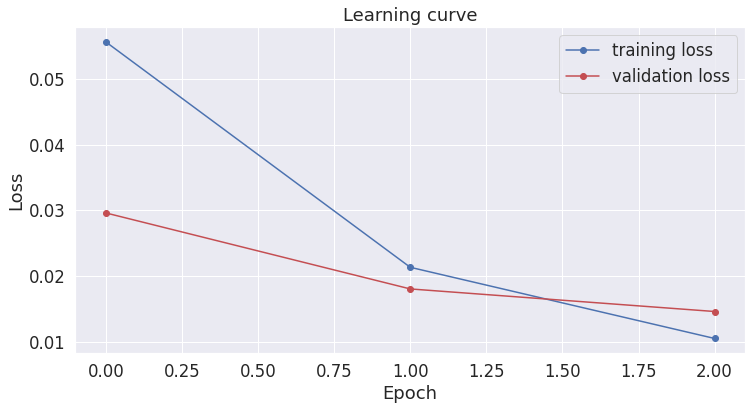

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


#Perdict

##預測資料整理(跟訓練差不多)

In [ ]:
testdata_list,testdata_article_id_list=Dataset2(data_path4)

In [ ]:
#testdata_list

In [ ]:
def turn_df2(x):
  test_df = pd.DataFrame(x, columns=["article_id","word","sentence_idx"])
  return test_df

In [ ]:
test_df=pd.concat(list(map(lambda x:turn_df2(x),testdata_list))).reset_index()
test_df=test_df.drop('index',axis=1)

In [ ]:
test_df

,article_id,word,sentence_idx
0,0,醫,0
1,0,師,0
2,0,：,0
3,0,最,0
4,0,近,0
...,...,...,...
270565,158,好,17631
270566,158,，,17631
270567,158,謝,17631
270568,158,謝,17631


In [ ]:
class SentenceGetter2(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w) for w in zip(s["word"].values.tolist())]
                                          
        self.grouped=self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter2 = SentenceGetter2(test_df)

In [ ]:
test_sentences =[[word[0] for word in sentence] for sentence in getter2.sentences]
test_sentences[0]

['醫', '師', '：', '最', '近', '人', '有', '沒', '有', '什', '麼', '不', '舒', '服', '？']

In [ ]:
len(test_sentences)

17632

進行定義一個預測的函數，並將它帶進list裡對每個句子進行預測

In [ ]:
def perdict_test(test_sentence):
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
  k=pd.DataFrame()
  k['tokens']=new_tokens
  k['labels']=new_labels
  return k

進行預測

In [ ]:
y_pred_df=pd.concat(list(map(lambda x:perdict_test(x),test_sentences))).reset_index()

資料整理，首先把為了讓bert看得懂而增加的mask去掉

In [ ]:
y_pred=y_pred_df[y_pred_df['tokens']!='[CLS]']
y_pred2=y_pred[y_pred_df['tokens']!='[SEP]']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
#y_pred2

In [ ]:
y_pred2=y_pred2.reset_index()

In [ ]:
test_df['labels']=y_pred2.labels

In [ ]:
test_df

,article_id,word,sentence_idx,labels
0,0,醫,0,O
1,0,師,0,O
2,0,：,0,O
3,0,最,0,O
4,0,近,0,O
...,...,...,...,...
270565,158,好,17631,O
270566,158,，,17631,O
270567,158,謝,17631,O
270568,158,謝,17631,O


In [ ]:
agg_func = lambda s: [(w) for w in s["labels"].values.tolist()]
y_pred=test_df.groupby("article_id").apply(agg_func)

In [ ]:
agg_func = lambda s: [(w) for w in s["word"].values.tolist()]
per_word=test_df.groupby("article_id").apply(agg_func)

In [ ]:
y_pred=list(y_pred)

In [ ]:
per_word=list(per_word)

## Output data
* Change model output into `output.tsv` 
* Only accept this output format uploading to competition system

In [ ]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for test_id in range(len(y_pred)):
    pos=0
    start_pos=None
    end_pos=None
    entity_text=None
    entity_type=None
    for pred_id in range(len(y_pred[test_id])):
        if y_pred[test_id][pred_id][0]=='B':
            start_pos=pos
            entity_type=y_pred[test_id][pred_id][2:]
      
        elif start_pos is not None and y_pred[test_id][pred_id][0]=='I' and y_pred[test_id][pred_id+1][0]=='O':
            end_pos=pos
            entity_text=''.join([per_word[test_id][position][0] for position in range(start_pos,end_pos+1)])
            line=str(testdata_article_id_list[test_id])+'\t'+str(start_pos)+'\t'+str(end_pos+1)+'\t'+entity_text+'\t'+entity_type
            output+=line+'\n'
            start_pos=None
        elif start_pos is not None and y_pred[test_id][pred_id][0]=='I' and len(y_pred[test_id])==pred_id:
          end_pos=pos
          entity_text=''.join([per_word[test_id][position][0] for position in range(start_pos,end_pos+1)])
          line=str(testdata_article_id_list[test_id])+'\t'+str(start_pos)+'\t'+str(end_pos+1)+'\t'+entity_text+'\t'+entity_type
          output+=line+'\n'
    
        pos+=1
        

In [ ]:
output_path='output10.tsv'
with open(output_path,'w',encoding='utf-8') as f:
    f.write(output)

In [ ]:
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	227	229	麻豆	location
0	237	239	麻豆	location
1	31	33	今天	time
1	40	42	昨天	time
1	76	80	0.79	med_exam
1	94	96	88	med_exam
1	122	124	60	med_exam
1	179	181	20	med_exam
1	182	184	19	med_exam
1	258	261	2.6	med_exam
1	360	363	黃醫師	name
1	366	369	6.6	med_exam
1	385	388	6.6	med_exam
1	394	397	8.3	med_exam
1	407	410	8.3	med_exam
1	414	417	四個月	time
1	418	421	8.3	med_exam
1	463	466	6.2	med_exam
1	469	472	三個月	time
1	626	629	黃醫師	name
1	663	666	格里曼	name
1	670	673	格里曼	name
1	720	723	格里曼	name
1	737	739	捷糖	name
1	747	750	格里曼	name
1	754	757	格里曼	name
1	867	869	21	med_exam
1	873	875	21	med_exam
1	881	883	12	time
1	890	892	12	time
1	902	906	三個星期	time
2	170	174	1100	med_exam
2	245	249	1145	med_exam
2	275	278	500	money
2	285	288	500	money
2	390	393	三個月	time
2	402	405	三個月	time
2	678	680	55	med_exam
2	681	683	57	med_exam
2	698	701	前52	med_exam
2	792	795	兩個月	time
2	1090	1094	7.56	med_exam
2	1151	1155	450塊	money
2	1202	1204	國中	time
2	1239	1241	35	med_exa

-----------------------------------------------------

最後分數：0.7282878